# The Data

The work performed herein was built off of the shoulders of giants, the original project that created the dataset and labeled the images. Here follows an excerpt from their site describing the data.

> [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4002935.svg)](https://doi.org/10.5281/zenodo.4002935)
>__Project member(s)__:\
>Topher Allen; Zach Anderson; Berlin Chen; Ameya Daigavane; Annie Didier; Marko Green; Paul Horton; Hannah Kerner; Lauren Klein; Benjamin Kolber; Ellie Kuang; Kyle Kung; Jake Lee; Justin Martia; Brian Milch; James Montgomery; Kyle Pearson; Sanjna Ravichandar; Arun Viswanathan; Caleb Wagner; Amruta Yelamanchili; Brandon Zhao
>
>__Abstract__:\
>This dataset contains a total of 64,947 landmark images that were detected and extracted from HiRISE browse images, spanning 232 separate source images.
>
>This set was formed from 10,815 original landmarks. Each original landmark was cropped to a square bounding box that included the full extent of the landmark plus a 30-pixel margin to the left, right, top, and bottom. Each landmark was then resized to 227x227 pixels. 9,022 of these images were then augmented to generate 6 additional landmarks using the following methods:
>
>90 degrees clockwise rotation
>180 degrees clockwise rotation
>270 degrees clockwise rotation
>Horizontal flip
>Vertical flip
>Random brightness adjustment
>The remaining 1,793 images were not augmented. Combining these with the 7*9,022 images, gives a total of 64,947 separate images.
>
> __Contents__:
>- map-proj-v3_2/: Directory containing individual cropped landmark images
>- labels-map-proj-v3_2.txt: Class labels (ids) for each landmark image. File includes two columns separated by a space: filename, class_id
>- labels-map-proj-v3_2_train_val_test.txt: Includes train/test/val labels and upsampling used for trained model. File includes three columns separated by a space: filename, class_id, set
>- landmarks_map-proj-v3_2_classmap.csv: Dictionary that maps class ids to semantic names
>
> __Class Discussion__:\
>We give a discussion of the various landmarks that make up our classes.
>
>Bright dune and dark dune are two sand dune classes found on Mars. Dark dunes are completely defrosted, whereas bright dunes are not. Bright dunes are generally bright due to overlying frost and can exhibit black spots where parts of the dune are defrosting.
>
>The crater class consists of crater images in which the diameter of the crater is greater than or equal to 1/5 the width of the image and the circular rim is visible for at least half the crater's circumference.
>
>The slope streak class consists of images of dark flow-like features on slopes. These features are believed to be formed by a dry process in which overlying (bright) dust slides down a slope and reveals a darker sub-surface.
>
>Impact ejecta refers to material that is blasted out from the impact of a meteorite or the eruption of a volcano. We also include cases in which the impact cleared away overlying dust, exposing the underlying surface. In some cases, the associated crater may be too small to see. Impact ejecta can also include lava that spilled out from the impact (blobby ("lobate") instead of blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in clusters when the impactor breaks up into multiple fragments.
>
>Spiders and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and they are believed to form as a result of sublimation of carbon dioxide ice. This process can produce mineral deposits on top, which look like dark or light dust that highlights cracks in the CO2 ice. Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta tends to have straight radial jets that fade as they get farther from the center. The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown by the wind away from the cracks. Fans are typically unidirectional (following the wind direction), whereas impact ejecta often extends in multiple directions. Swiss cheese is a terrain type that consists of pits that are formed when the sun heats the ice making it sublimate (change solid to gas).
>
>Other is a catch-all class that contains images that fit none of the defined classes of interest. This class makes up the majority of our data set.


# Business Understanding

Space exploration and understanding has been growing over the last few decades with the spark being lit during the space race during the latter half of the 20th century. After the end of the Apollo space program, man's venture into space has been relegated to low earth orbit missions.  

Unmanned missions have since had many a success story such as the Voyager 2 going interstellar in 2018, over 40 years after its launch. The future of space exploration is going to be handled by such manned missions for the foreseeable future. However, being physically on site isn't the only way to explore space.  

For centuries, man has looked up at the night sky to find out more about our celestial neighbors. With improvements in technologies our ability to gather data through telescopes and cameras has improved significantly and the value provided by telescopes in space has been immeasurable. The James Webb (infrared) telescope was launched in December 2021 and hopes to view objects too old, distant, and faint for the Hubble Space Telescope.

Pointing the telescope and gathering data is only the first step. Being able to parse terabytes, petabytes or even yottabytes of data manually is a nigh impossible task, a task computer vision is especially suited for. Being able to identify interesting features can help us whittle down potential candidates to explore 'in-person' and in the long run help mitigate losses.

Interest in space exploration has seen a resurgence with private enterprise taking an interest. Although this project specifically looks at the Mars topography, similar techniques can be applied to any celestial body, or even to our home planet.

# Overview
We shall be using images captured from the HiRISE camera system on board the Mars Reconnaisance Orbiter which was built under direction from University of Arizona's Lunar and Planetary Laboratory. Following is an excerpt from the [University of Arizona website](https://www.lpl.arizona.edu/missions/hirise-mro).

>The __Hi__gh __R__esolution __I__maging __S__cience __E__xperiment (HiRISE) onboard the Mars Reconnaissance Orbiter, is the most powerful camera ever sent to another planet. The resolution of the camera allows us to see the Red Planet in amazing detail, and lets other missions, like the Mars Science Laboratory, find a safe place to land and carry out amazing science. The operations center, which includes not only observation planning, but the execution of commands sent to the spacecraft along with actual image processing, is located within LPL at the University of Arizona.

We shall be building off of the work performed by the original team. The dataset comes pre-augmented and segmented into training, validation and test sets. The test side will be set aside to ascertain effectiveness of our final model. The training set will be used to train the model and the validation scores on the validation set will be used as a metric to pick our model, specifically our validation loss.

# Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf

seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
import seaborn as sns

tf_chkpt_path = 'tf_TransferLearning_8Classes'

In [12]:
from src.helperFunctions import display_model_trainTestGraphs

# Training Set

In [13]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=2,
    color_mode='rgb',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [14]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=10,
    color_mode='rgb',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [15]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

## Modeling Callbacks
Tensorflow's neural networks employs callbacks which allow for additional features.

The disadvantage of having a high learning rate is the model may not converge and bounce around the optimal solution, while the disadvantage of a small learning rate is the model has to train longer to get to a solution. LearningRateScheduler is a callback that allows us to change the learning rate of the algorithm _during_ the training process. Using such a tool can allow us to get the best of both worlds. 
It can be exact learning rates for sets of epochs if desired, however, we are going to use it to decrease by a percentage for every epoch past epoch 10. 

In [16]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    elif epoch >105:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
    
    
lr_schd_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

ModelCheckpoint as the name suggests allows us to create a checkpoint and save the model. By default, a model will retain the weights of the last epoch, however depending upon your parameters and how long the model was run it may not be the best parameters. I used it to capture model weights for the epoch where validation loss was at its minimum.

In [17]:
best_model = ModelCheckpoint(tf_chkpt_path+'_best_model.hdf5', 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             save_freq='epoch')

We'll also be using a CSVLogger callback to make a dedicated log file that will capture all metrics for every epoch at the end of the epoch for posterity and visualizations

In [18]:
csv_logger = CSVLogger('./logs/TransferLearning_VGG16_Logger.log', separator=',', append=False)

# VGG 16

![img](./savedFigs/vgg16-neural-network.jpg)

In 2014, Karen Simonyan, Andrew Zissermanren wrote a paper on _Very Deep Convolutional Networks for Large-Scale Image Recognition_ using 16/19 layer variations of the same architecture called [VGG](https://arxiv.org/abs/1409.1556). This architecture has seen tremendous success in a variety of different arenas.  

As part of the above paper the two variations tested are colloquially called `VGG16` and `VGG19`.  

VGG16 achieves 92.7% top-5 test accuracy in *ImageNet*, a dataset comprising of over 14 million images belonging to 1000 distinct classes. The weights resulting from training the architecture for weeks is the same weights we will be using to initialize our model.  

The original model was designed to work off of an *RGB* image sized *224x224*. To account for this our dataset is loaded as an RGB image even though it is natively a grayscale image. An additional `Flatten()` and `softmax` layer corresponding to our number of classes is added after the `vgg` layer.

In [19]:
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    classes=8,
    classifier_activation='softmax',
    input_shape=(227,227,3),
)

In [20]:
model = tf.keras.Sequential([
  vgg,
  layers.Flatten(),
    layers.Dense(8, activation='softmax')
])


model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy',
#                        Precision(),
#                        Recall()
                       ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 200712    
                                                                 
Total params: 14,915,400
Trainable params: 14,915,400
Non-trainable params: 0
_________________________________________________________________


In [21]:
results = model.fit(train_generator,
                    steps_per_epoch=75,
                    epochs=500,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
                        best_model
                    ]
                    )

Epoch 1/500
75/75 [==============================] - ETA: 0s - loss: 1.1379 - accuracy: 0.6867
Epoch 1: val_loss improved from inf to 0.81131, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 89s 1s/step - loss: 1.1379 - accuracy: 0.6867 - val_loss: 0.8113 - val_accuracy: 0.7916 - lr: 1.0000e-05
Epoch 2/500
75/75 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.8133
Epoch 2: val_loss did not improve from 0.81131
75/75 [==============================] - 74s 1s/step - loss: 0.7397 - accuracy: 0.8133 - val_loss: 0.8514 - val_accuracy: 0.7893 - lr: 1.0000e-05
Epoch 3/500
75/75 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.8400
Epoch 3: val_loss improved from 0.81131 to 0.72945, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 75s 1s/step - loss: 0.6439 - accuracy: 0.8400 - val_loss: 0.7294 - val_accuracy: 0.7920 - lr: 1.0000e-05
Epoch 4/

Epoch 28/500
75/75 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9467
Epoch 28: val_loss did not improve from 0.52588
75/75 [==============================] - 74s 1s/step - loss: 0.1736 - accuracy: 0.9467 - val_loss: 0.6564 - val_accuracy: 0.8183 - lr: 8.7810e-06
Epoch 29/500
74/75 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8716
Epoch 29: val_loss did not improve from 0.52588
75/75 [==============================] - 75s 1s/step - loss: 0.4008 - accuracy: 0.8667 - val_loss: 0.5728 - val_accuracy: 0.8401 - lr: 8.6936e-06
Epoch 30/500
75/75 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.9067
Epoch 30: val_loss did not improve from 0.52588
75/75 [==============================] - 75s 1s/step - loss: 0.2816 - accuracy: 0.9067 - val_loss: 0.6659 - val_accuracy: 0.8262 - lr: 8.6071e-06
Epoch 31/500
74/75 [============================>.] - ETA: 0s - loss: 0.3337 - accuracy: 0.9189
Epoch 31: val_loss did not improve

Epoch 55/500
75/75 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9600
Epoch 55: val_loss did not improve from 0.45781
75/75 [==============================] - 75s 1s/step - loss: 0.2174 - accuracy: 0.9600 - val_loss: 0.4823 - val_accuracy: 0.8624 - lr: 6.7032e-06
Epoch 56/500
74/75 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8851
Epoch 56: val_loss did not improve from 0.45781
75/75 [==============================] - 75s 1s/step - loss: 0.3303 - accuracy: 0.8733 - val_loss: 0.5177 - val_accuracy: 0.8429 - lr: 6.6365e-06
Epoch 57/500
74/75 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9662
Epoch 57: val_loss did not improve from 0.45781
75/75 [==============================] - 74s 1s/step - loss: 0.1765 - accuracy: 0.9667 - val_loss: 0.4906 - val_accuracy: 0.8595 - lr: 6.5705e-06
Epoch 58/500
74/75 [============================>.] - ETA: 0s - loss: 0.2908 - accuracy: 0.9054
Epoch 58: val_loss did not improve

75/75 [==============================] - 59s 797ms/step - loss: 0.1964 - accuracy: 0.9400 - val_loss: 0.5452 - val_accuracy: 0.8531 - lr: 4.0252e-06
Epoch 110/500
75/75 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9467
Epoch 110: val_loss did not improve from 0.40745
75/75 [==============================] - 59s 796ms/step - loss: 0.2480 - accuracy: 0.9467 - val_loss: 0.4726 - val_accuracy: 0.8662 - lr: 4.0252e-06
Epoch 111/500
75/75 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9600
Epoch 111: val_loss did not improve from 0.40745
75/75 [==============================] - 59s 794ms/step - loss: 0.1253 - accuracy: 0.9600 - val_loss: 0.4081 - val_accuracy: 0.8839 - lr: 4.0252e-06
Epoch 112/500
75/75 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9667
Epoch 112: val_loss did not improve from 0.40745
75/75 [==============================] - 59s 797ms/step - loss: 0.1392 - accuracy: 0.9667 - val_loss: 0.4128 - val_

75/75 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9333
Epoch 137: val_loss did not improve from 0.39977
75/75 [==============================] - 59s 792ms/step - loss: 0.2191 - accuracy: 0.9333 - val_loss: 0.5767 - val_accuracy: 0.8261 - lr: 4.0252e-06
Epoch 138/500
75/75 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9333
Epoch 138: val_loss did not improve from 0.39977
75/75 [==============================] - 59s 793ms/step - loss: 0.2088 - accuracy: 0.9333 - val_loss: 0.4344 - val_accuracy: 0.8727 - lr: 4.0252e-06
Epoch 139/500
75/75 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9467
Epoch 139: val_loss did not improve from 0.39977
75/75 [==============================] - 59s 793ms/step - loss: 0.1273 - accuracy: 0.9467 - val_loss: 0.4280 - val_accuracy: 0.8768 - lr: 4.0252e-06
Epoch 140/500
75/75 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9800
Epoch 140: val_loss did not impr

Epoch 164/500
75/75 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9200
Epoch 164: val_loss did not improve from 0.37676
75/75 [==============================] - 59s 795ms/step - loss: 0.2337 - accuracy: 0.9200 - val_loss: 0.4081 - val_accuracy: 0.8852 - lr: 4.0252e-06
Epoch 165/500
75/75 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9400
Epoch 165: val_loss did not improve from 0.37676
75/75 [==============================] - 59s 796ms/step - loss: 0.1294 - accuracy: 0.9400 - val_loss: 0.3913 - val_accuracy: 0.8874 - lr: 4.0252e-06
Epoch 166/500
75/75 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9867
Epoch 166: val_loss did not improve from 0.37676
75/75 [==============================] - 59s 796ms/step - loss: 0.0664 - accuracy: 0.9867 - val_loss: 0.4335 - val_accuracy: 0.8882 - lr: 4.0252e-06
Epoch 167/500
75/75 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9533
Epoch 167: val_los

Epoch 192/500
75/75 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9533
Epoch 192: val_loss did not improve from 0.37598
75/75 [==============================] - 59s 794ms/step - loss: 0.1577 - accuracy: 0.9533 - val_loss: 0.4290 - val_accuracy: 0.8813 - lr: 4.0252e-06
Epoch 193/500
75/75 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.9200
Epoch 193: val_loss improved from 0.37598 to 0.37016, saving model to tf_TransferLearning_8Classes_best_model.hdf5
75/75 [==============================] - 59s 800ms/step - loss: 0.2885 - accuracy: 0.9200 - val_loss: 0.3702 - val_accuracy: 0.8943 - lr: 4.0252e-06
Epoch 194/500
75/75 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9800
Epoch 194: val_loss did not improve from 0.37016
75/75 [==============================] - 59s 797ms/step - loss: 0.0955 - accuracy: 0.9800 - val_loss: 0.4003 - val_accuracy: 0.8932 - lr: 4.0252e-06
Epoch 195/500
75/75 [============================

Epoch 247/500
75/75 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9933
Epoch 247: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 795ms/step - loss: 0.0249 - accuracy: 0.9933 - val_loss: 0.4788 - val_accuracy: 0.8887 - lr: 4.0252e-06
Epoch 248/500
75/75 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9800
Epoch 248: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 793ms/step - loss: 0.0903 - accuracy: 0.9800 - val_loss: 0.4384 - val_accuracy: 0.8970 - lr: 4.0252e-06
Epoch 249/500
75/75 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9533
Epoch 249: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 794ms/step - loss: 0.1731 - accuracy: 0.9533 - val_loss: 0.4675 - val_accuracy: 0.8686 - lr: 4.0252e-06
Epoch 250/500
75/75 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9600
Epoch 250: val_los

Epoch 275/500
75/75 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9467
Epoch 275: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 796ms/step - loss: 0.1211 - accuracy: 0.9467 - val_loss: 0.4169 - val_accuracy: 0.8953 - lr: 4.0252e-06
Epoch 276/500
75/75 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9533
Epoch 276: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 796ms/step - loss: 0.1804 - accuracy: 0.9533 - val_loss: 0.4062 - val_accuracy: 0.8909 - lr: 4.0252e-06
Epoch 277/500
75/75 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9667
Epoch 277: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 796ms/step - loss: 0.0835 - accuracy: 0.9667 - val_loss: 0.4070 - val_accuracy: 0.8988 - lr: 4.0252e-06
Epoch 278/500
75/75 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9733
Epoch 278: val_los

Epoch 303/500
75/75 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9867
Epoch 303: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 795ms/step - loss: 0.0448 - accuracy: 0.9867 - val_loss: 0.3829 - val_accuracy: 0.9037 - lr: 4.0252e-06
Epoch 304/500
75/75 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9600
Epoch 304: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 796ms/step - loss: 0.1153 - accuracy: 0.9600 - val_loss: 0.4376 - val_accuracy: 0.8771 - lr: 4.0252e-06
Epoch 305/500
75/75 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9667
Epoch 305: val_loss did not improve from 0.35825
75/75 [==============================] - 59s 795ms/step - loss: 0.0931 - accuracy: 0.9667 - val_loss: 0.4526 - val_accuracy: 0.8844 - lr: 4.0252e-06
Epoch 306/500
75/75 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9867
Epoch 306: val_los

Epoch 331/500
75/75 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9600
Epoch 331: val_loss did not improve from 0.33860
75/75 [==============================] - 59s 795ms/step - loss: 0.1061 - accuracy: 0.9600 - val_loss: 0.4322 - val_accuracy: 0.8863 - lr: 4.0252e-06
Epoch 332/500
75/75 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9467
Epoch 332: val_loss did not improve from 0.33860
75/75 [==============================] - 59s 794ms/step - loss: 0.1858 - accuracy: 0.9467 - val_loss: 0.3924 - val_accuracy: 0.8907 - lr: 4.0252e-06
Epoch 333/500
75/75 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9867
Epoch 333: val_loss did not improve from 0.33860
75/75 [==============================] - 59s 794ms/step - loss: 0.0924 - accuracy: 0.9867 - val_loss: 0.3877 - val_accuracy: 0.8963 - lr: 4.0252e-06
Epoch 334/500
75/75 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 1.0000
Epoch 334: val_los

Epoch 359/500
75/75 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9733
Epoch 359: val_loss did not improve from 0.33860
75/75 [==============================] - 59s 797ms/step - loss: 0.0702 - accuracy: 0.9733 - val_loss: 0.4148 - val_accuracy: 0.8914 - lr: 4.0252e-06
Epoch 360/500
75/75 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9467
Epoch 360: val_loss did not improve from 0.33860
75/75 [==============================] - 59s 795ms/step - loss: 0.1249 - accuracy: 0.9467 - val_loss: 0.8492 - val_accuracy: 0.8005 - lr: 4.0252e-06
Epoch 361/500
75/75 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9667
Epoch 361: val_loss did not improve from 0.33860
75/75 [==============================] - 59s 796ms/step - loss: 0.1356 - accuracy: 0.9667 - val_loss: 0.4008 - val_accuracy: 0.8952 - lr: 4.0252e-06
Epoch 362/500
75/75 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9600
Epoch 362: val_los

Epoch 387/500
75/75 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9933
Epoch 387: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 794ms/step - loss: 0.0311 - accuracy: 0.9933 - val_loss: 0.4004 - val_accuracy: 0.8999 - lr: 4.0252e-06
Epoch 388/500
75/75 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9733
Epoch 388: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.1442 - accuracy: 0.9733 - val_loss: 0.3633 - val_accuracy: 0.9062 - lr: 4.0252e-06
Epoch 389/500
75/75 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9933
Epoch 389: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.0351 - accuracy: 0.9933 - val_loss: 0.3884 - val_accuracy: 0.9033 - lr: 4.0252e-06
Epoch 390/500
75/75 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9800
Epoch 390: val_los

Epoch 415/500
75/75 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9600
Epoch 415: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.0941 - accuracy: 0.9600 - val_loss: 0.4282 - val_accuracy: 0.8880 - lr: 4.0252e-06
Epoch 416/500
75/75 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9800
Epoch 416: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 794ms/step - loss: 0.0834 - accuracy: 0.9800 - val_loss: 0.3845 - val_accuracy: 0.9049 - lr: 4.0252e-06
Epoch 417/500
75/75 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9600
Epoch 417: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 794ms/step - loss: 0.1240 - accuracy: 0.9600 - val_loss: 0.3942 - val_accuracy: 0.9048 - lr: 4.0252e-06
Epoch 418/500
75/75 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9867
Epoch 418: val_los

Epoch 443/500
75/75 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9533
Epoch 443: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 794ms/step - loss: 0.1433 - accuracy: 0.9533 - val_loss: 0.4918 - val_accuracy: 0.8833 - lr: 4.0252e-06
Epoch 444/500
75/75 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9667
Epoch 444: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.0829 - accuracy: 0.9667 - val_loss: 0.4832 - val_accuracy: 0.8904 - lr: 4.0252e-06
Epoch 445/500
75/75 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9600
Epoch 445: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 794ms/step - loss: 0.2185 - accuracy: 0.9600 - val_loss: 0.5129 - val_accuracy: 0.8659 - lr: 4.0252e-06
Epoch 446/500
75/75 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9667
Epoch 446: val_los

Epoch 471/500
75/75 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9733
Epoch 471: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 796ms/step - loss: 0.0720 - accuracy: 0.9733 - val_loss: 0.7279 - val_accuracy: 0.8420 - lr: 4.0252e-06
Epoch 472/500
75/75 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9733
Epoch 472: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 794ms/step - loss: 0.0458 - accuracy: 0.9733 - val_loss: 0.4208 - val_accuracy: 0.8978 - lr: 4.0252e-06
Epoch 473/500
75/75 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9733
Epoch 473: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.0738 - accuracy: 0.9733 - val_loss: 0.4134 - val_accuracy: 0.8939 - lr: 4.0252e-06
Epoch 474/500
75/75 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9933
Epoch 474: val_los

Epoch 499/500
75/75 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9533
Epoch 499: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.0793 - accuracy: 0.9533 - val_loss: 0.4000 - val_accuracy: 0.9031 - lr: 4.0252e-06
Epoch 500/500
75/75 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9733
Epoch 500: val_loss did not improve from 0.33556
75/75 [==============================] - 59s 795ms/step - loss: 0.0524 - accuracy: 0.9733 - val_loss: 0.4630 - val_accuracy: 0.9010 - lr: 4.0252e-06


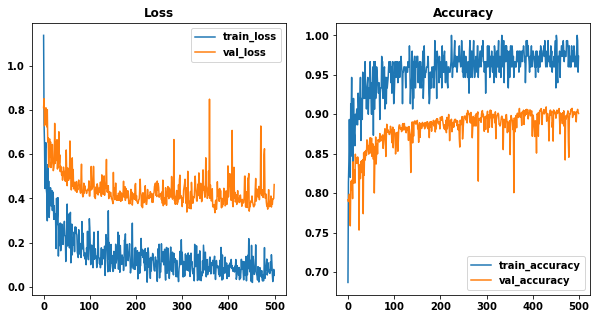

In [22]:
display_model_trainTestGraphs(results)

In [26]:
m = models.load_model('tf_TransferLearning_8Classes_best_model.hdf5')
m.save('tf_TransferLearning_8class_VGG16.hfpy')

In [28]:
m.evaluate(val_generator)

1418/1418 [==============================] - 57s 40ms/step - loss: 0.3356 - accuracy: 0.9073


[0.33556196093559265, 0.9073016047477722]

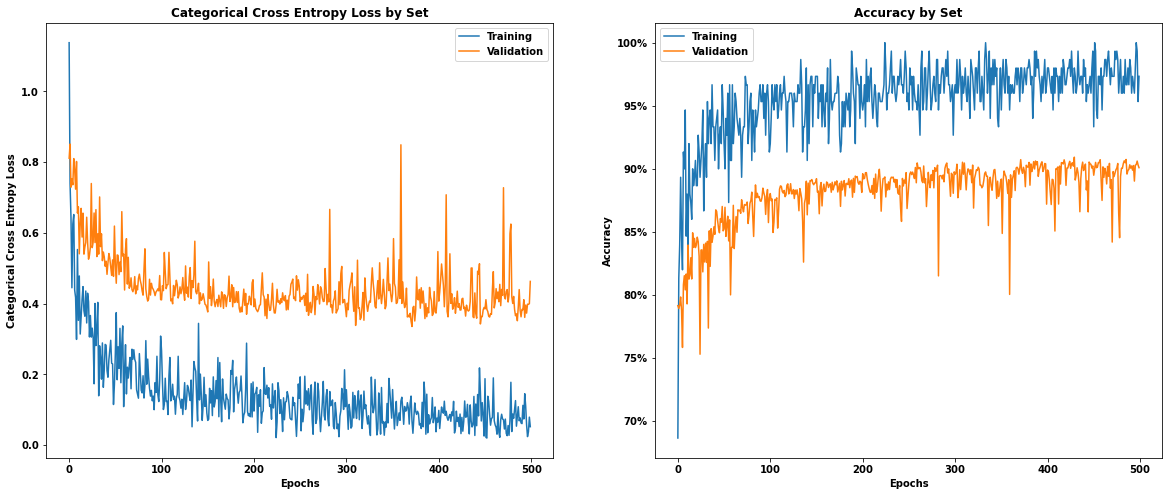

In [32]:
model_log = pd.read_csv('./logs/TransferLearning_VGG16_Logger.log')


train_loss = model_log['loss']
train_acc = model_log['accuracy']    

val_loss = model_log['val_loss']
val_acc = model_log['val_accuracy']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))


ax1.plot(model_log['epoch'],train_loss)
ax1.plot(model_log['epoch'],val_loss)
ax1.set_title('Categorical Cross Entropy Loss by Set')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Categorical Cross Entropy Loss')
ax1.legend(['Training', 'Validation'])

ax2.plot(model_log['epoch'],train_acc)
ax2.plot(model_log['epoch'],val_acc)
ax2.set_title('Accuracy by Set')
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(f'{round(x*100)}%'))
)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(['Training', 'Validation'])

plt.savefig('./savedFigs/VGG_TransferLearning_Performance.jpg', dpi='figure', 
          bbox_inches='tight', pad_inches=0.1,
          facecolor='auto', edgecolor='auto',
         )

plt.show()